# Validação e Regularização

## Revisão 

### Aprendizado supervisionado

$$ X \xrightarrow{\text{f}} y $$

- Minimização do erro empírico - _Empirical Risk Minimization_ (o que isso significa?) 
- Aprendizado estatístico
- Dados identicamente independentemente distribuídos (iid)
- Queremos prever um valor de interesse, não estamos interessados (geralmente) no formato da 𝒇

--- 

Na aula passada aprendemos sobre regressão linear. 

Uma forma de decompor um valor de interesse (__target__, $y$) em uma soma ponderada (a função $f$) de variáveis explicativas ($X$).

$$ y = \beta_{0} + \beta_{0}*x_{1} + \beta_{2}*x_{2} + \epsilon $$

Foi dito que para encontrar os melhores $ \beta $s usaríamos uma solução que minimiza o erro quadrático, o MQO (mínimos quadrados ordinários).

Também como foi dito, em aplicações de Machine Learning é usado um método iterativo para encontrar uma solução que minimize o erro quadrático médio. 

O erro é a diferença entre valor real ($y$) e valor previsto ($X\beta$). Posso fazer esse erro ao quadrado e pegar a média em relação a cada ponto do conjunto de dados, no final, teríamos:


$$Loss(\beta) = \frac{1}{n} \sum^{n}_{i=1} (y_{i} - x_{i}^{T}\beta)^{2} $$

Então essa é a perda e nós queremos minimizá-la. Os $\beta$s são aprendidos de acordo com uma técnica chamada *gradiente descendente* e para saber mais [veja aqui](https://www.youtube.com/watch?v=F6GSRDoB-Cg).

O importante a saber por enquanto é: nós buscamos aprender a nossa $f$ que conecta dados de entrada em  um dado de saída ao minimizar essa função de custo nos dados de treino. 

O que poderia dar errado?

## De volta aos slides!

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn, matplotlib
import warnings

from matplotlib import pyplot as plt

# Isso esconderá os warnings
warnings.filterwarnings('ignore')

print("Pandas:,", pd.__version__)
print("Numpy:,", np.__version__)
print("Sklearn:,", sklearn.__version__)
print("matplotlib:,", matplotlib.__version__)

Pandas:, 0.24.2
Numpy:, 1.16.3
Sklearn:, 0.20.3
matplotlib:, 3.0.3


## Dados

Vamos começar utilizando como exemplo os dados da competição [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [2]:
# Carregando os dados
data = pd.read_csv("train.csv")
target = "SalePrice"

# Resolvendo o problema de missing, mas não da melhor forma! 
data.fillna(data.median(), inplace=True)
# Transformando o target no log do valor
data[target] = np.log1p(data[target])
# Excluindo os outliers
data = data[data["LotArea"] <= data["LotArea"].quantile(0.95)]

In [3]:
print("Existem {} colunas no conjunto de dados".format(data.shape[1]))
print(data.columns)

Existem 81 colunas no conjunto de dados
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'Garag

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


## Construindo o melhor modelo para minimizar o erro!

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
def plot_regressao(data, model, features, target, plot_feature):
    """
    Faz o plot das previsões geradas por uma regressão em relação à uma única 
    variável.
    """
    plt.clf()
    plt.figure(figsize=(14, 10))
    plt.scatter(data[plot_feature], 
                data[target],
                label="Valores reais")
    
    plt.scatter(data[plot_feature],
                model.predict(data[features]),
                color="r",
                s=1.5,
                label="Valores previstos")    
    plt.legend()
    plt.xlabel(plot_feature)
    plt.ylabel(target)
    plt.title("Valores estimados pela regressão")
    plt.show()
    

def plot_regressao_order_p(data, model, target, plot_feature, order):   
    """
    Faz o plot de uma regressão em relação à uma única variável adicionando até
    o termo de ordem order no polinômio como variável de entrada.
    """
    features = [plot_feature]
    for k in range(2, order + 1):
        data["LotArea" + str(k)] = data["LotArea"] ** k
        features += ["LotArea" + str(k)]
    
    model.fit(data[features], data[target])
    
    plot_regressao(data,
                   model, 
                   features,
                   target,
                   plot_feature=features[0])

<Figure size 432x288 with 0 Axes>

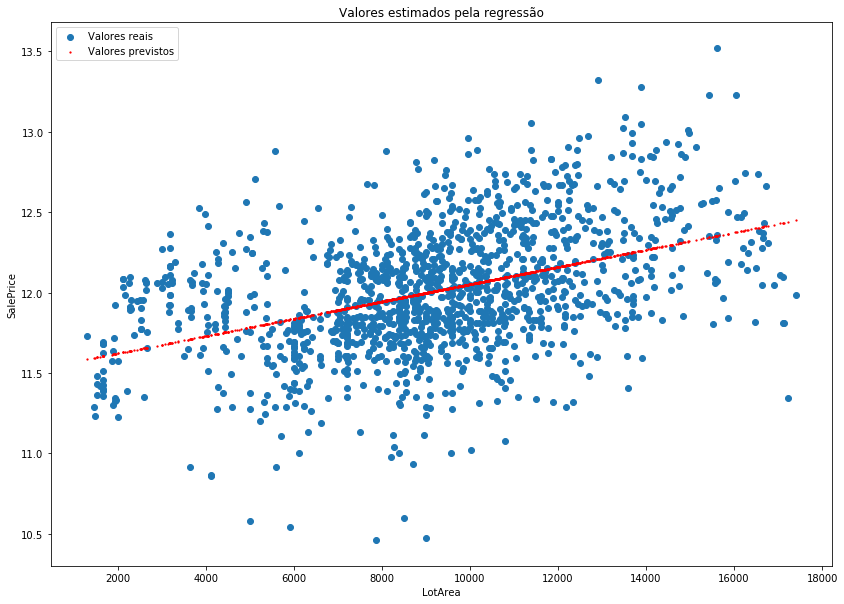

In [7]:
plot_regressao_order_p(data,
                       LinearRegression(normalize=True),
                       target, 
                       plot_feature="LotArea", 
                       order=1)

<Figure size 432x288 with 0 Axes>

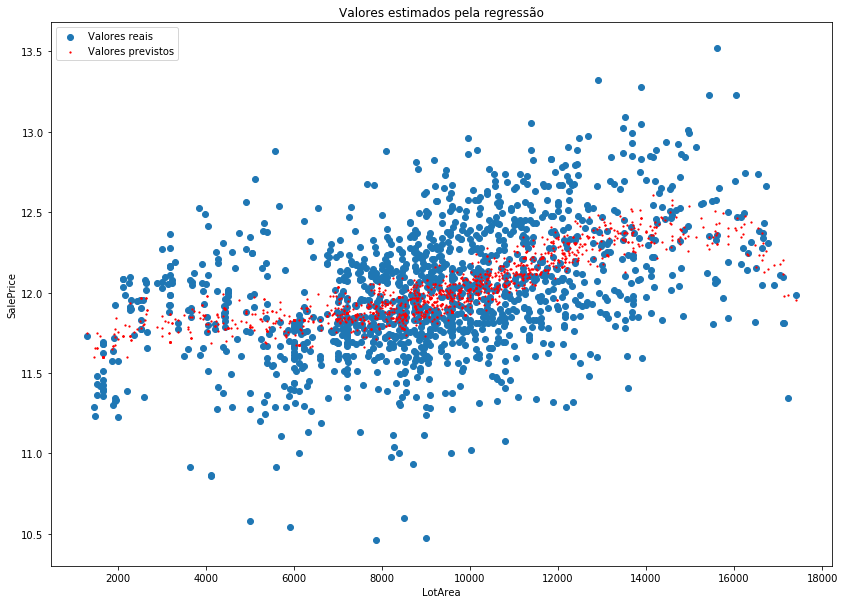

In [8]:
plot_regressao_order_p(data,
                       LinearRegression(normalize=True),
                       target, 
                       plot_feature="LotArea", 
                       order=30)

Se o problema do overfitting é prejudicar as previsões, como saberei se este é o caso?

## De volta aos slides!

.  
.  
.  
.  
.  
.  
.  
.  
.  
. 

## E se eu fizer de conta que...

...uma parcela dos dados é desconhecida enquanto eu desenvolvo o modelo?

**Exercício**:

1. Separar os nossos dados em uma base de treino e teste (80/20).

Para tal você utilizará o [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do sklearn. Veja a documentação no link para entender como implementar.

2. Calcular o MSE para o conjunto de treino e teste para as versões do modelo com ordem máxima para `LotArea` de 1, 2, 5, 10 e 30.

3. Comentar a diferença dos resultados para cada uma das versões.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## SEU CODIGO AQUI!

Houve algum padrão na variação do erro de treino e teste quando aumentamos a complexidade?

**Discussão 1**: como complexidade e os erros no treino e teste se relacionam?

Você fez uma escolha para realizar essa divisão: qual proporção fica para treino e qual fica para teste.

**Discussão 2**: como tomar essa decisão? O que está envolvida nela?

# -> Checkpoint! <-

## De volta aos slides!

.  
.  
.  
.  
.  
.  
.  
.  
.  
. 

## Validação cruzada

Eu gostaria de treinar o meu modelo com todos os dados possíveis.

Tem uma forma mais robusta e inteligente de testar o nosso modelo. 

**Exercício**: 

1. Utilizar `k-fold` com 5 folds para validar o seu modelo. Faça apenas para as versões de grau 1, 5, 10 e 30.
2. Comparar com os resultados anteriores.

Você utilizará o [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [10]:
from sklearn.model_selection import KFold

## SEU CODIGO AQUI!

**Discussão**: como foi o resultado em comparação com o caso anterior?

# -> Checkpoint! <-

## Ok, agora sei identificar overfitting, mas como evitá-lo?

**Regularização!**

## Lasso e Ridge

- Lasso
$$Loss(\beta) = \frac{1}{n} \sum^{n}_{i=1} (y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum^{k}_{j=1}\mid\beta_{j}\mid$$

- Ridge
$$Loss(\beta) = \frac{1}{n} \sum^{n}_{i=1} (y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum^{k}_{j=1}\beta^{2}_{j}$$



## Regularização para combater o overfitting!

Sempre que aplicamos Machine Learning queremos ter um bom desempenho preditivo. Saber com alta acurácia um evento futuro nos dá uma vantagem para tomar uma ação melhor. Portanto, o overfitting degrada o valor que nosso modelo entrega. Lembre-se que o valor dos seus projetos em Machine Learning sempre virão das **previsões em produção**!

#### Exercício em sala

Imagine que agora você foi **contratado como cientista de dados em uma imoboliária**. Um dos negócios dela é intermediar a compra e venda de imóveis e é útil ter um modelo para prever o preço de um casa dadas as suas características.

O cientista de dados anterior construiu um modelo para tal usando o `LotArea` até o grau 30, porém, ele apresenta problemas (e foi por isso que o demitiram e contrataram você!). 

**Questões**:
1. Escrava um parágrafo explicando para a sua equipe qual foi o problema encontrado
2. Utilize regularização L2 (Ridge) para mitigar o problema. 
3. Compare o resultado encontrado com o dos exercícios anteriores

In [11]:
## SEU CÓDIGO AQUI!

## Regularização para seleção de variáveis

Um cenário comum em empresas é: tenho centenas de variáveis para criar um modelo. Porém, ao colocar em produção é preciso monitorar e dar manutenção em todas elas, então deve-se utilizá-las com sabedoria (ou seja, só incluir as que valem a pena). 

Como vimos, regularização L1 é útil para fazer seleção de variáveis. 

#### Exercício em sala

Após identificar o problema, porém, você foi informado que soluções que usam muitas variáveis apresentariam um custo maior de implementação e manuntenção (ok, aqui estamos usando apenas variáveis derivadas de uma só, mas imagine que elas são de fontes diferentes!). A sua equipe agora quer levantar alternativas sobre desempenho e quantidade de variáveis para apresentar.

**Questão**:
1. Utilize regularização L1 para selecionar as variáveis e justifique o desempenho e quantidade de variáveis final para a sua equipe através de um parágrafo. 
2. Compare o resultado com os anteriores.

Tome como ponto de partida o modelo com o `LotArea` até o grau 30 acima.

In [12]:
from sklearn.linear_model import LassoCV, Lasso
## SEU CÓDIGO AQUI!

# -> Checkpoint! <-

## Revisitando o exemplo da aula anterior

Bom, agora sabemos validar!

Que tal aplicarmos no exemplo da aula anterior?

## De volta aos slides!

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  

## Pós aula

### Regularização está em todos os lugares!

Regularização não é uma exclusividade da regressão linear e é uma técnica utilizada em uma grande variedade de modelos!

Porém, o foco é sempre o mesmo: controlar a complexidade do modelo visando favorecer o poder de generalização.

#### Exercícios

**Regularização em outros modelos**:  
Pesquise qual é o termo de regularização para os seguintes modelos:

- SVM
- Neural Networks
- XGBoost

O primeiro e mais importante ponto é identificar o termo/parâmetro. Segundo, caso haja interesse, busque detalhes de como a regularização "atua" no modelo. Ou seja, o que aumentar ou diminuir o termo associado à ela modifica no modelo. 

Mesmo que você ainda não tenha aprendido sobre estes modelos, vale a pena uma pesquisa breve sobre!

**Validação**: 

Como visto na apresentação, validação é algo que pode ser sutil e é bem específico de cada caso. Para treinar um pouco o nosso "senso-do-que-devo-me-preocupar-quando-estiver-validando-um-modelo-em-diferentes-situações", descreva com o que você se preocuparia e como escolheria validar os modelos gerados em cada uma das seguintes situações:

1. Uma plataforma de streaming de música quer construir um sistema de recomendação e possui um dataset com execução de músicas e um critério de sucesso;
2. Um banco quer automatizar as suas decisões de crédito e passará a utilizar um modelo para decidir empréstimos;
3. Um sistema de cadastro que usa fotos enviadas por usuários gostaria de identificar automaticamente quando eles enviam uma foto borrada e que não pode ser usada;

**Praticando**:

A competição [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) está no Kaggle para servir de tutorial, então é um ótimo lugar para experimentar o que aprendemos: crie uma conta no Kaggle e entre nela!

Seus objetivos são: 1) criar um esquema de validação que faça com que o desempenho estimado fique o mais próximo possível daquele calculado pelo Kaggle quando a sua resposta é submetida e 2) utilizar regularização em um modelo de regressão para controlar o _overfitting_!

Aproveite o recurso do **kernel** para aprender! O Kernel é simplesmente um pedaço de código que as pessoas compartilham no Kaggle em relação a competição. Considerando a _House Prices_ e o assunto da aula, seria interessante ler o [Regularized linear models](https://www.kaggle.com/apapiu/regularized-linear-models)!